In [1]:
### Importing stuff

import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import xlrd

In [2]:
### Parser

list_of_TIKS = []
for i in range (1, 31):
    list_of_TIKS.append('Территориальная избирательная комиссия №' + str(i))

num_of_voters = []
num_of_voters_voted = []
appearence = []
votes_for_Amosov_percent = []
votes_for_Beglov_percent = []
votes_for_Tikhonova_percent = []

url = "http://www.st-petersburg.vybory.izbirkom.ru/region/region/st-petersburg?action=show&root=1&tvd=27820001217417&vrn=27820001217413&region=78&global=&sub_region=78&prver=0&pronetvd=null&vibid=27820001217417&type=222"
response = requests.get(url)
page = BeautifulSoup(response.content, "lxml")

main_links = page.find_all('a')
for TIK in list_of_TIKS:
    for main_tag in main_links:
        main_link = main_tag.get('href')
        if TIK in main_tag:
            current_TIK = pd.read_html(main_link, encoding='cp1251',  header=0)[7]
            
            num_of_voters.extend(int(current_TIK.iloc[0,i]) for i in range (len(current_TIK.columns)))
            num_of_voters_voted.extend(int(current_TIK.iloc[2,i]) + int(current_TIK.iloc[3,i]) for i in range (len(current_TIK.columns)))
            appearence.extend(round((int(current_TIK.iloc[2,i]) + int(current_TIK.iloc[3,i]))/int(current_TIK.iloc[0,i])*100, 2) for i in range (len(current_TIK.columns)))
            
            votes_for_Amosov_percent.extend(round(float(current_TIK.iloc[12,i][-6]+current_TIK.iloc[12,i][-5]+current_TIK.iloc[12,i][-4]+current_TIK.iloc[12,i][-3]+current_TIK.iloc[12,i][-2]),2) for i in range (len(current_TIK.columns)))
            votes_for_Beglov_percent.extend(round(float(current_TIK.iloc[13,i][-6]+current_TIK.iloc[13,i][-5]+current_TIK.iloc[13,i][-4]+current_TIK.iloc[13,i][-3]+current_TIK.iloc[13,i][-2]),2) for i in range (len(current_TIK.columns)))
            votes_for_Tikhonova_percent.extend(round(float(current_TIK.iloc[14,i][-6]+current_TIK.iloc[14,i][-5]+current_TIK.iloc[14,i][-4]+current_TIK.iloc[14,i][-3]+current_TIK.iloc[14,i][-2]),2) for i in range (len(current_TIK.columns)))


In [3]:
### Plots Data

#Votes in percent (appearence) - no need in extra computations

#Appearence (num of voters) - no need in extera computations

#Number of UIKs (appearence)
interval = 1

interval_num_of_UIKs = []

for i in range (int(100/interval+1/interval)):
    interval_num_of_UIKs.append(0)

for i in range (0, int(100/interval+1/interval), interval):
    for j in range (len(appearence)):
        if appearence[j] < (i + interval/2) and appearence[j] >= (i - interval/2):
            interval_num_of_UIKs[i] = interval_num_of_UIKs[i] + 1

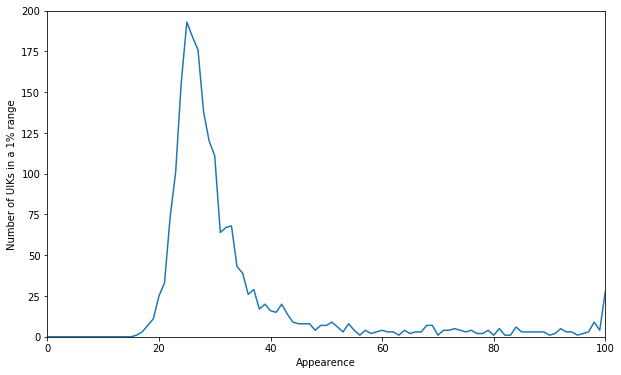

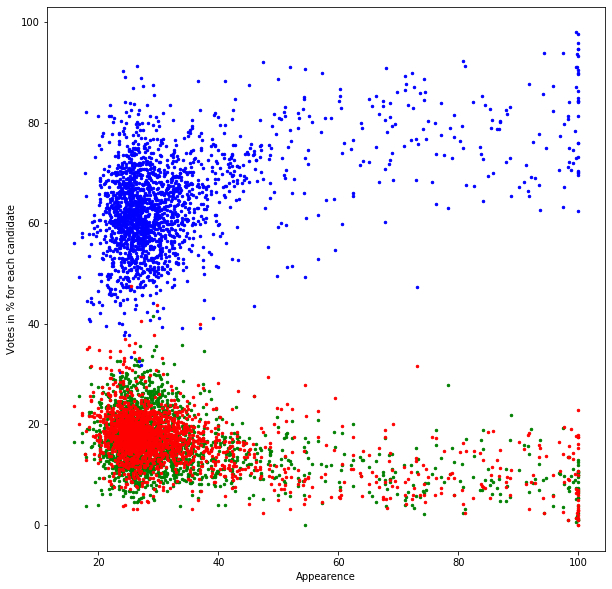

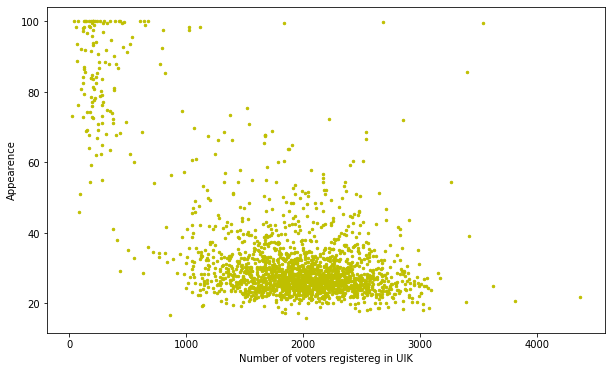

In [4]:
### Plotting

#Number of UIKs (appearence)

plt.figure(figsize=(10, 6))
plt.plot(interval_num_of_UIKs)
plt.axis([0, 100, 0, 200])
plt.ylabel('Number of UIKs in a 1% range')
plt.xlabel('Appearence')
plt.show()

#Votes in percent (appearence)

plt.figure(figsize=(10, 10))
plt.scatter(appearence, votes_for_Amosov_percent, c = 'g', s = 6)
plt.scatter(appearence, votes_for_Beglov_percent, c = 'b', s = 6)
plt.scatter(appearence, votes_for_Tikhonova_percent, c = 'r', s = 6)
plt.ylabel('Votes in % for each candidate')
plt.xlabel('Appearence')
plt.show()

#Appearence (num of voters)

plt.figure(figsize=(10, 6))
plt.scatter(num_of_voters, appearence, c = 'y', s = 6)
plt.ylabel('Appearence')
plt.xlabel('Number of voters registereg in UIK')
plt.show()

In [5]:
### Extra data for visualization: appearence and number of voters by municipal districts

current_UIK = pd.read_html(url, encoding='cp1251',  header=0)[7]

num_of_voters_dist = []
num_of_voters_voted_dist = []
appearence_dist = []

for j in [num_of_voters_dist, num_of_voters_voted_dist, appearence_dist]:
    j.extend(0 for i in range (18))

districts = {
    '0' : [1], #Адмиралтейский
    '1' : [2], #Василеостровский 
    '2' : [18], #Петроградский
    '3' : [16, 30], #Центральный
    '4' : [10, 14, 22], #Выборгский
    '5' : [11, 17], #Калининский
    '6' : [4, 25], #Красногвардейский
    '7' : [5, 24], #Невский
    '8' : [23, 29], #Фрунзенский
    '9' : [9, 12, 28], #Приморский
    '10' : [13], #Курортный
    '11' : [15], #Кронштадтский
    '12' : [21], #Колпинский
    '13' : [20], #Пушкинский
    '14' : [19, 27], #Московский
    '15' : [3, 7], #Кировский
    '16' : [6, 26], #Красносельский
    '17' : [8] #Петродворцовый
}

for i in districts.keys():
    for k in range (1, 31):
        if k in districts[i]:
            num_of_voters_dist[int(i)]= num_of_voters_dist[int(i)] + int(current_UIK.iloc[0,k-1])
            num_of_voters_voted_dist[int(i)] = num_of_voters_voted_dist[int(i)] + int(current_UIK.iloc[2,k-1]) + int(current_UIK.iloc[3,k-1])

for i in range (18):
    appearence_dist[i] = round(num_of_voters_voted_dist[i]/num_of_voters_dist[i]*100, 2)

In [6]:
### GeoDataFrame 

SPb_shapes= gpd.read_file('./shapes/Administrative_Discrits.shp', encoding='cp1251')

temp = pd.DataFrame({'Количество избирателей': num_of_voters_dist, 'Явка':appearence_dist })
temp['Район'] = SPb_shapes[['Район']]
temp['geometry'] = SPb_shapes[['geometry']]
SPB_elections_visualization = gpd.GeoDataFrame(temp)

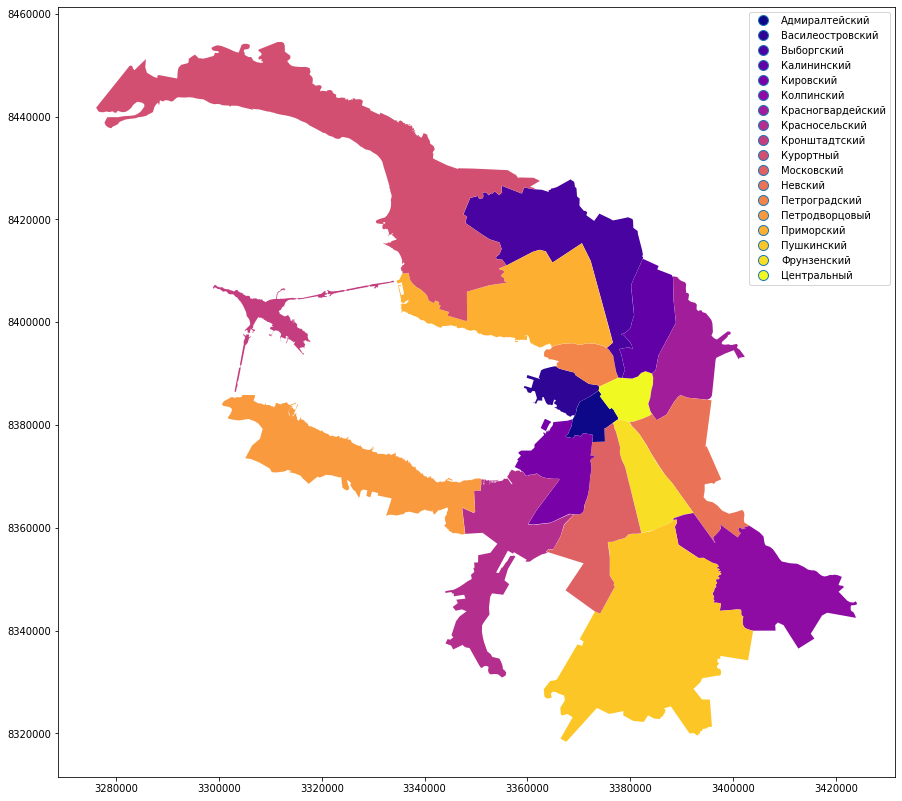

In [7]:
### Colored districts

SPB_elections_visualization.plot(column = 'Район', linewidth=0, cmap='plasma', legend=True, figsize=[15,15])

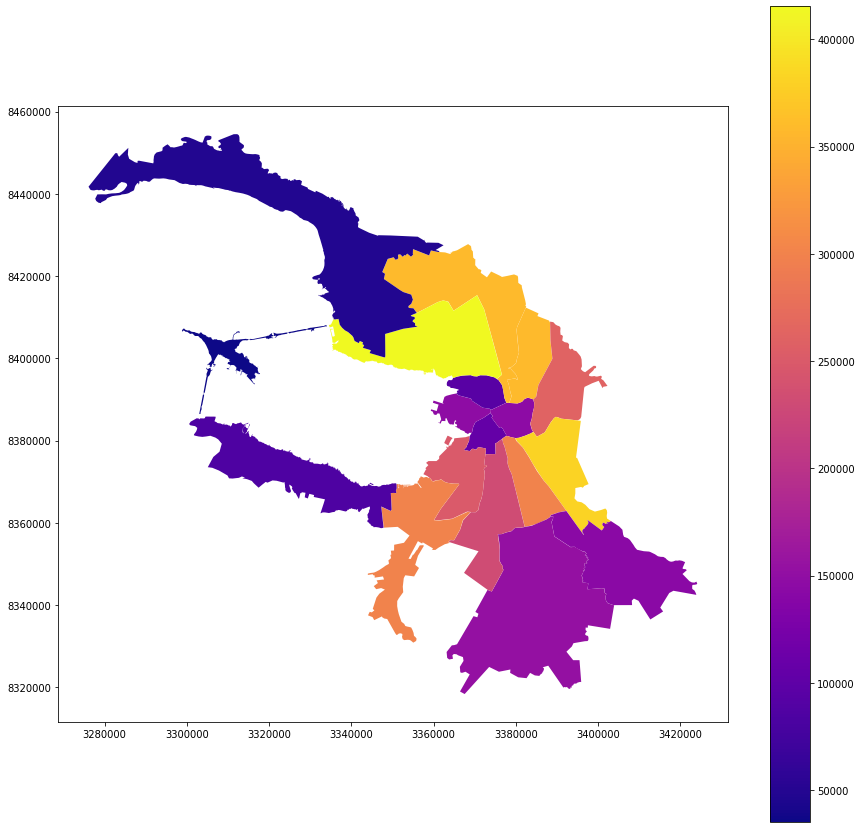

In [8]:
### Number of voters gradient

SPB_elections_visualization.plot(column = 'Количество избирателей', linewidth=0, cmap='plasma', legend=True, figsize=[15,15])

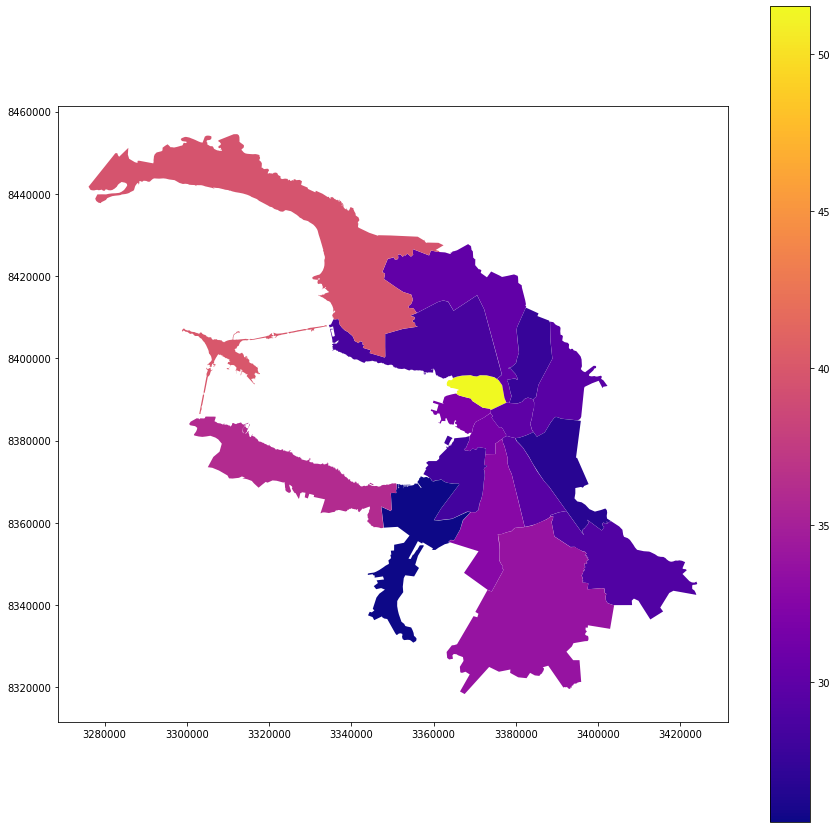

In [9]:
### Appearence gradient

SPB_elections_visualization.plot(column = 'Явка', linewidth=0, cmap='plasma', legend=True, figsize=[15,15])